In [199]:
from langgraph.graph import StateGraph, START, END
from pydantic import  BaseModel
from dotenv import load_dotenv
from typing import List,Annotated,TypedDict, Literal
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

In [200]:
load_dotenv()

tweet_generation_llm = ChatOpenAI(model="gpt-4o-mini")
tweet_evaluation_llm = ChatGroq(model="llama-3.1-8b-instant")
tweet_optimizer_llm = ChatOpenAI(model="gpt-4o")

class Tweet_evaluation(BaseModel):
  
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str


tweet_evaluation_llm_structure = tweet_evaluation_llm.with_structured_output(Tweet_evaluation)

In [201]:
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    

In [202]:
def tweet_generation(state: TweetState):
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    response = tweet_generation_llm.invoke(messages).content

    return {"tweet":response}

In [203]:
def tweet_evaluation(state: TweetState):
    evaluation_messages = [
    SystemMessage(content="You are a social media expert and meme analyst reviewing tweets for quality."),
    HumanMessage(content=f"""Your task is to evaluate this tweet and decide if it’s good enough to be posted.Tweet:
    "{state['tweet']}"

    Evaluate based on:
    - Humor (clever, witty, or relatable)
    - Originality (not generic or overused)
    - Clarity (easy to understand)
    - Punchiness (ends strong or surprising)

    Rules:
    - Reply in JSON format like:
    {{
        "verdict": "approve" or "reject",
        "reason": "Brief 1-2 sentence reason"
    }}
    """)
    ] 
    response = tweet_evaluation_llm_structure.invoke(evaluation_messages)

    return {"evaluation": response.evaluation, "feedback": response.feedback}




In [204]:
def optimize_tweet(state: TweetState):
    messages = [
    SystemMessage(content = "You punch up tweets for virality and humor based on given feedback."),
    HumanMessage(content=f"""
    Improve the tweet based on this feedback:
    (state['feedback' ])
    Topic: "(state['topic'])*
    Original Tweet:
    (state['tweet'])
    Re-write it as a short, viral-worthy tweet. Avoid QIA style and stay under 280 characters.
    """)
    ]
    response = tweet_optimizer_llm.invoke(messages).content
    state["iteration"] += 1
    return {"tweet": response,"iteration": state["iteration"] + 1}

In [205]:
def route_evaluation(state:TweetState):
    if state["evaluation"] == "approved" or state["iteration"] >= state["max_iteration"]:
        return "approved"
   
    else:
        return "needs_improvement"

In [206]:
state = StateGraph(TweetState)
state.add_node("tweet_generation", tweet_generation)
state.add_node("tweet_evaluation",tweet_evaluation)
state.add_node("tweet_optimizer", optimize_tweet)

state.add_edge(START,"tweet_generation")
state.add_edge("tweet_generation","tweet_evaluation")
state.add_conditional_edges("tweet_evaluation", route_evaluation , {"approved":END, "needs_improvement": "tweet_optimizer"})
state.add_edge("tweet_optimizer", "tweet_evaluation")


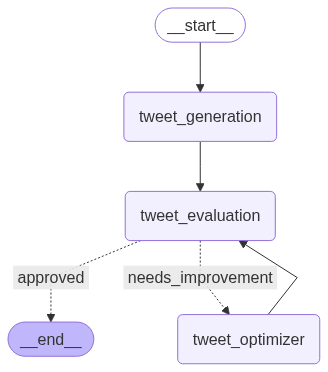

In [207]:
workflow = state.compile()

workflow

In [208]:
initial_state = {
    "topic": "adkflaljhdg",
    "iteration": 1,
    "max_iteration": 5
}

workflow.invoke(initial_state)

{'topic': 'adkflaljhdg',
 'tweet': '"Adkflaljhdg: the universal sound of trying to type while laughing and accidentally summoning a new language. Sounds like my phone’s desperate attempt to translate my chaotic thoughts into an ancient dialect of ‘Oops!’ 😂📱"',
 'evaluation': 'approved',
 'feedback': 'The tweet uses clever wordplay, has a relatable concept, and ends with a strong punchline. The use of emojis adds to its humor and clarity.',
 'iteration': 1,
 'max_iteration': 5}